<h3>Question 1</h3>

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from unidecode import unidecode
import numpy as np
import seaborn as sns
from tabulate import tabulate

In [2]:
# For World Bank datasets

############################################################

# This function imports the data from the csv files of the world bank, and since some of the data requires
# some rows to be skipped, I put the parameters to be the csv file and no_of_rows_to_skip. Moreover, since some of
# the countries have special character and accented letters, I want to make sure that they are not, and they all
# have the same letters. I did that because I was running into some issues while parsing some code and selecting
# certain rows. That way everything would be the same.
def import_world_bank_csv(csv, no_of_rows_to_skip):
    
    data = pd.read_csv(csv, skiprows=no_of_rows_to_skip)
    
    for column in data.columns:
        
        if data[column].dtype == "object":
            
            # This was on this forum:
            # https://stackoverflow.com/questions/54650276/if-not-this-or-this-then-in-lambda-python-pandas
            # Trial and error basically
            data[column] = data[column].apply(lambda x: unidecode(str(x)) if isinstance(x, str) else x)
            
    return data

def adjust_and_clean_csv(dataframe, data_name):
    
    # Locating the column that contains unnamed, (did it as a subset because some columns contain 68 and some 5)
    dataframe = dataframe.loc[:, ~dataframe.columns.str.contains('^Unnamed')]
    # Removing more useless columns and cleaning up the data
    dataframe = dataframe.drop(columns=['Indicator Name', 'Indicator Code'])
    # Found the melt function on stackexchange to put the headers in the columns so I can better manipulate the
    # data. It makes it easier for me to merge and plot later on. 
    # Note: I first ran through the code normally before I found the use to build the code into functions.
    dataframe = dataframe.melt(id_vars=['Country Name', 'Country Code'], var_name='Year', value_name = data_name)
    # Changing the year column to numeric insted of strings.
    dataframe['Year'] = pd.to_numeric(dataframe['Year'])
    
    return dataframe
# Nested functions to import and clean CSVs directly.
def import_and_clean(csv, no_of_rows_to_skip, data_name):
    
    clean_dataframe = import_world_bank_csv(csv, no_of_rows_to_skip)
    clean_dataframe = adjust_and_clean_csv(clean_dataframe, data_name)
    
    return clean_dataframe

############################################

# For worldbank regions and income levels. I thought about doing one function that imports this stuff, but I
# got a little lazy, but that works also.

def import_region_and_income_level(region_and_income_csv):
    # imports the data from regions_and_income.csv specifically as denoted by skiprows number that I set to 0
    regions_and_income_dataframe = import_world_bank_csv(region_and_income_csv, 0)
    #it locates approximate titles of unnamed, just like the adjust_and_clean_csv function
    regions_and_income_dataframe = regions_and_income_dataframe.loc[:, ~regions_and_income_dataframe.columns.str.contains('^Unnamed')]
    
    regions_and_income_dataframe = regions_and_income_dataframe.drop(columns=["SpecialNotes"])
    
    regions_and_income_dataframe = regions_and_income_dataframe[["TableName", 
                                                                 "Country Code", 
                                                                 "Region", 
                                                                 "IncomeGroup"]]
    regions_and_income_dataframe.columns = ["Country Name", "Country Code", "Region", "Income Level"]
    
    regions_and_income_dataframe = regions_and_income_dataframe.dropna(subset = "Region")
    
    return regions_and_income_dataframe

######################################################

# the datasets for GDP, Ferility, and Malnutrtion include data for regions as well. To only include countries,
# I used the regions_and_income.csv file as a reference after dropping all the regions and unions from it. This way
# I would ensure that only countries and regions are included. I used the regions_and_income.csv file because 
# it is the most inclusive, and I can chop the countries that are not in it.

def filter_datasets_to_include_proper_countries(dataframe_to_fit, dataframe_reference):
    
    valid_countries = dataframe_reference["Country Name"].unique()
    
    fitted_dataframe = dataframe_to_fit[dataframe_to_fit["Country Name"].isin(valid_countries)]
    
    return fitted_dataframe
# this is to properly merge datafframes together. I will use this to combine dataframes together for easier manipulation
def combine_columns_from_another_dataframe(from_dataframe, to_dataframe):
    
    common_columns = list(set(from_dataframe.columns).intersection(set(to_dataframe.columns)))
    
    combined_frame = pd.merge(to_dataframe, from_dataframe, on = common_columns,
                              how = "right")
    
    return combined_frame

In [3]:
gdp = import_and_clean("gdp.csv", 4, "GDP Per Capita")
malnutrition = import_and_clean("malnutrition.csv", 4, "% Malnutrition")
income = import_region_and_income_level("regions_and_income.csv")

In [4]:
gdp_filtered = filter_datasets_to_include_proper_countries(gdp, income)
malnutrition_filtered = filter_datasets_to_include_proper_countries(malnutrition, income)

In [5]:
gdp_malnutrition = combine_columns_from_another_dataframe(gdp_filtered, malnutrition_filtered)

<h4>For Graph of %Underweight vs GDP</h4>

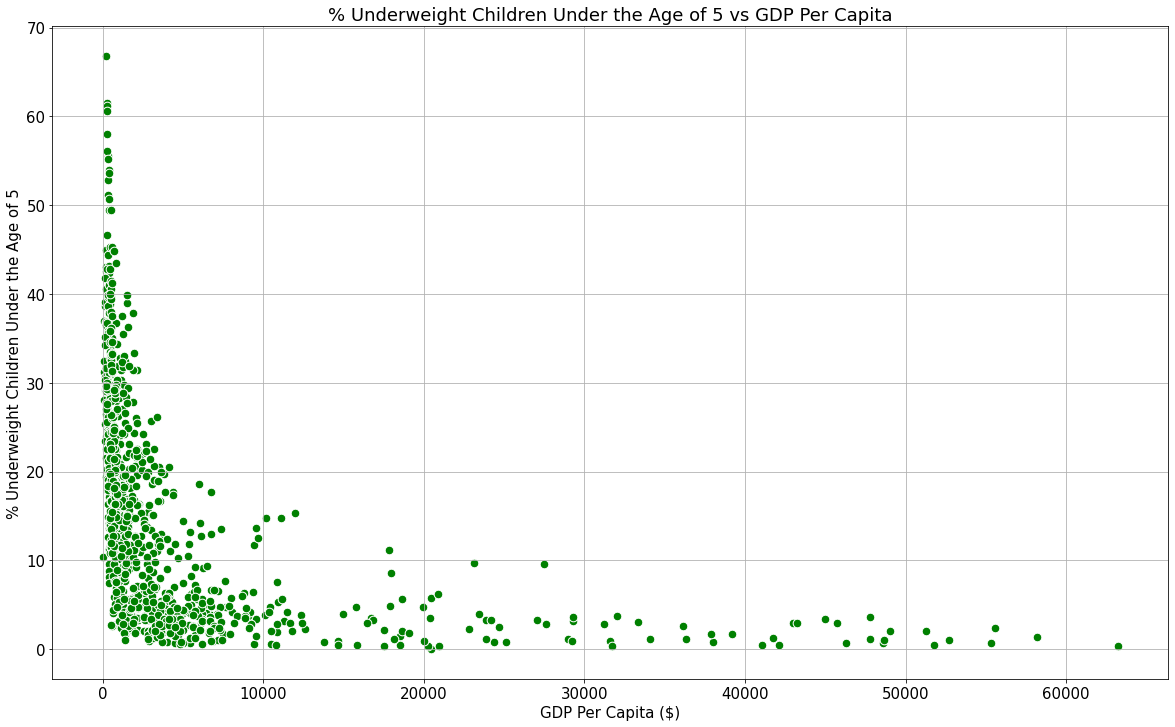

In [6]:
# I used the sane logic for all graphs, so I won't comment on similar things, but rather new code that I use
# plotting parameters for size and font
plt.figure(figsize = (20, 12))
plt.rcParams.update({"font.size": 15})

# plotting the graph itself
plt.scatter(gdp_malnutrition["GDP Per Capita"],
            gdp_malnutrition["% Malnutrition"],
            color = "green", 
            edgecolors = "w", 
            s = 75)

#x and y axis names and graph title
plt.title('% Underweight Children Under the Age of 5 vs GDP Per Capita')
plt.xlabel('GDP Per Capita ($)')
plt.ylabel('% Underweight Children Under the Age of 5')
#showing the major grid
plt.grid(True)
plt.show()

In [7]:
# calculating the percentage of datapoints between 0:10% and 0:10,000 dollars
percentage_0_10 = len(gdp_malnutrition[(gdp_malnutrition["% Malnutrition"] <= 10) & (gdp_malnutrition["GDP Per Capita"] <= 10000)]["Country Name"].unique())/ (
len(gdp_malnutrition["Country Name"].unique()))
print(round(percentage_0_10, 2)*100)

35.0


In [8]:
# calculating the percentage of datapoints between 10:30% and 0:10,000 dollars
percentage_10_30 = len(gdp_malnutrition[(gdp_malnutrition["% Malnutrition"] >= 10) & (gdp_malnutrition["GDP Per Capita"] <= 10000)]["Country Name"].unique()) / (
len(gdp_malnutrition["Country Name"].unique()))
print(round(percentage_10_30, 2)*100)

43.0


<h4>For Graph of %Underweight vs GDP: By Region, Excluding North America</h4>

In [9]:
gdp_malnutrition_incomelevel_region = combine_columns_from_another_dataframe(gdp_malnutrition, income)

In [10]:
gdp_malnutrition_all_but_north_america = gdp_malnutrition_incomelevel_region[gdp_malnutrition_incomelevel_region["Region"] != "North America"]

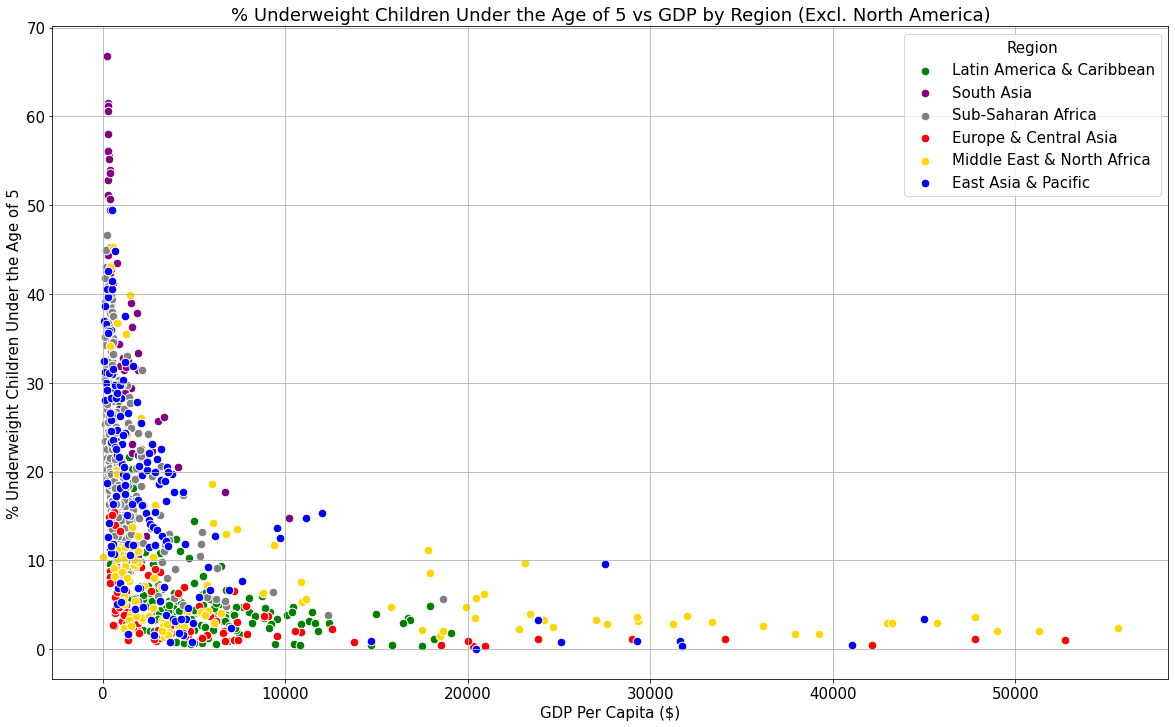

In [11]:
# setting the color dictionary so I can color code each scatter plot
colors = {
    'East Asia & Pacific': 'blue',
    'Europe & Central Asia': 'red',
    'Latin America & Caribbean': 'green',
    'Middle East & North Africa': 'gold',
    'South Asia': 'purple',
    'Sub-Saharan Africa': 'grey'
}

plt.figure(figsize=(20, 12))
plt.rcParams.update({"font.size": 15})

for region in gdp_malnutrition_all_but_north_america["Region"].unique():
    
    plt.scatter(gdp_malnutrition_all_but_north_america[gdp_malnutrition_all_but_north_america['Region'] == region]['GDP Per Capita'],
               gdp_malnutrition_all_but_north_america[gdp_malnutrition_all_but_north_america['Region'] == region]['% Malnutrition'],
               label=region,
               color=colors[region],
               edgecolors="w",
               s=75)

plt.xlabel('GDP Per Capita ($)')
plt.ylabel('% Underweight Children Under the Age of 5')
plt.title('% Underweight Children Under the Age of 5 vs GDP by Region (Excl. North America)')
plt.legend(title='Region')
plt.grid(True)
plt.show()

<h4>For Graph of %Underweight vs GDP: By Income Level</h4>

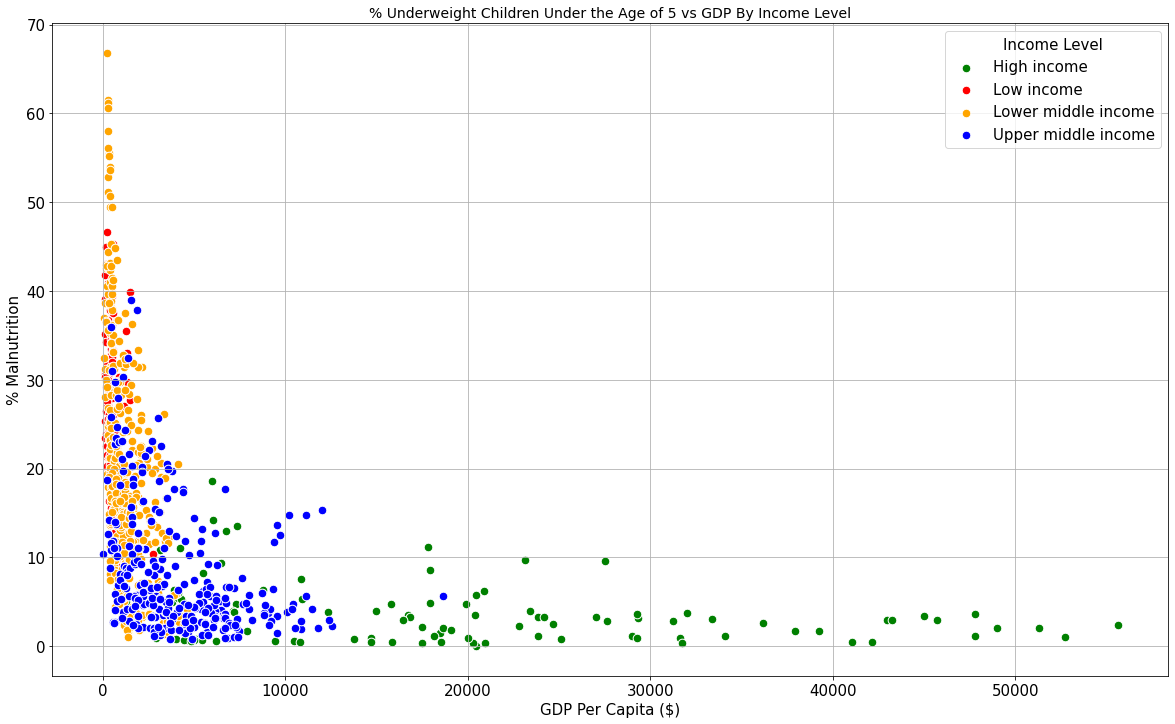

In [12]:
color_map_income = {
    'Low income': 'red',
    'Lower middle income': 'orange',
    'Upper middle income': 'blue',
    'High income': 'green'
}

plt.figure(figsize = (20, 12))
plt.rcParams.update({'font.size': 15})

for income_level in gdp_malnutrition_all_but_north_america["Income Level"].unique():
    # I was getting errors when not running an if statement, so I added it because Venezuela has a NaN value in 
    # income group
    if pd.notna(income_level):
                       
        plt.scatter(gdp_malnutrition_all_but_north_america[gdp_malnutrition_all_but_north_america['Income Level'] == income_level]['GDP Per Capita'],
                   gdp_malnutrition_all_but_north_america[gdp_malnutrition_all_but_north_america['Income Level'] == income_level]['% Malnutrition'],
                   label = income_level, 
                   color = color_map_income[income_level],
                   edgecolors = 'w',
                   s = 75)

plt.xlabel('GDP Per Capita ($)')
plt.ylabel('% Malnutrition')
plt.title('% Underweight Children Under the Age of 5 vs GDP By Income Level', fontsize=14)
plt.legend(title='Income Level')
plt.grid(True)

plt.show()

<h3>Question 2</h3>

In [13]:
#api_key = "WQUsck3cvw8iyHBifRmM"

#nasdaqdatalink.read_key(filename=api_key)

#wheat_ticker = "COM/PWHEAMT_USD"
#crude_oil_ticker = "WGEC/WLD_CRUDE_WTI"
#gold_ticker = "BUNDESBANK/BBK01_WT5511"

In [14]:
crude_oil = pd.read_csv('crude-oil.csv')
gold = pd.read_csv('gold.csv')
wheat = pd.read_csv('wheat.csv')

In [15]:
# adding the dataframes to a list so I can loop over them. just for efficiency
commodities = [crude_oil, gold, wheat]
commodities_columns = ["Crude Oil", "Gold", "Wheat"]

In [16]:
# looping to set the date column to datetime format then renaming the "Value" columns to their signifcant names
# also setting the index to datetime as a preference really.

i = 0

for commodity in commodities:
    
    commodity["Date"] = pd.to_datetime(commodity["Date"])
    commodity.columns = ["Date", commodities_columns[i]]
    commodity.set_index("Date", inplace = True)
    
    i += 1

In [17]:
# combining both dataframes together
combined_commodities = pd.concat(commodities, axis = 0)

In [18]:
# replacing 0 values with NaN because I want to make sure that I don't graph zeros which would shift the price to
# something not accurate
combined_commodities.replace(0, np.nan, inplace=True)

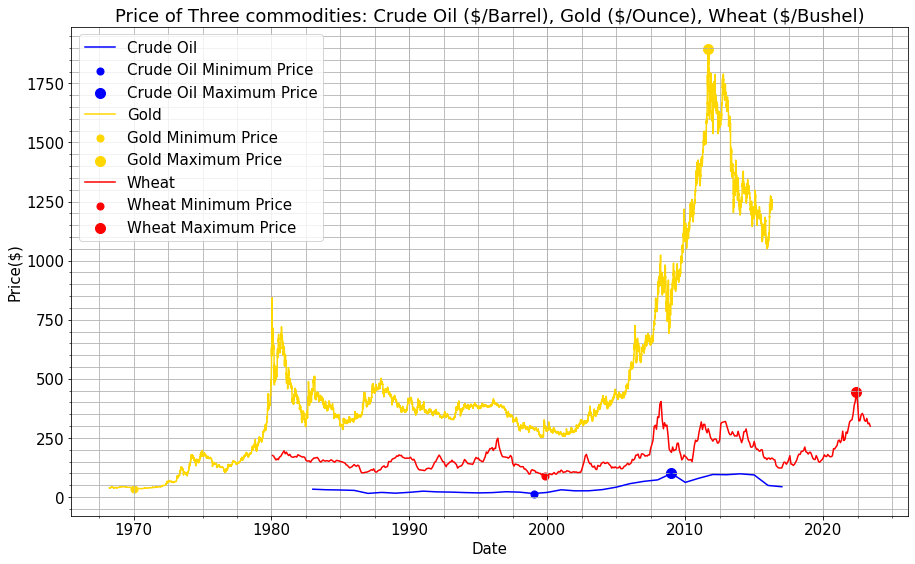

In [19]:
# If what is meant by synchronizing is just to make sure that they are all on the correct start and end timelines

colors = {
    "Wheat": "red",
    "Gold": "gold",
    "Crude Oil": "blue"
}

plt.figure(figsize = (15, 9))
plt.rcParams.update({'font.size': 15})
# for loop that plot each graph for each commodity, then finds the min and max prices in the time series and then
# plots them on the graph using plt.scatter for each. 
for commodity in combined_commodities:

    plt.plot(combined_commodities.index,
             combined_commodities[commodity],
             label = commodity,
             color = colors[commodity])
    # min price point calculation
    minimum_price = combined_commodities[commodity].min()
    minimum_date = combined_commodities[combined_commodities[commodity] == minimum_price].index[0]
    # max price point calculation
    maximum_price = combined_commodities[commodity].max()
    maximum_date = combined_commodities[combined_commodities[commodity] == maximum_price].index[0]
    # plot of min point of commodity
    plt.scatter(minimum_date, minimum_price, 
                color = colors[commodity], 
                marker = "o", s = 50 ,
                label = f"{commodity} Minimum Price")
    # plot of max point of commodity
    plt.scatter(maximum_date,
                maximum_price,
                color = colors[commodity],
                marker = "o", s = 100,
                label = f"{commodity} Maximum Price")
    
plt.xlabel("Date")
plt.ylabel("Price($)")
plt.title("Price of Three commodities: Crude Oil ($/Barrel), Gold ($/Ounce), Wheat ($/Bushel)")
plt.legend()
plt.grid(True, which = "both")
plt.minorticks_on()

<h3>Question 3</h3>

In [20]:
co2_per_capita_tonnes = import_and_clean("co2_per_capita.csv", 4, "CO2 Per Capita in Tonnes")
school_enrollment = import_and_clean("school.csv", 4, "% School Enrollment")

In [21]:
co2_per_capita_tonnes = filter_datasets_to_include_proper_countries(co2_per_capita_tonnes, income)
school_enrollment = filter_datasets_to_include_proper_countries(school_enrollment, income)

In [22]:
co2_per_capita_tonnes_2010 = co2_per_capita_tonnes[co2_per_capita_tonnes["Year"] == 2010]
school_enrollment_2010 = school_enrollment[school_enrollment["Year"] == 2010]

In [23]:
co2_per_capita_tonnes_2010_not_reported = co2_per_capita_tonnes_2010[co2_per_capita_tonnes["CO2 Per Capita in Tonnes"].isna()]
school_enrollment_2010_not_reported = school_enrollment_2010[school_enrollment_2010["% School Enrollment"].isna()]

/var/folders/mv/w58n0t094j1_0td5w0b14jy00000gn/T/ipykernel_12901/738029677.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  co2_per_capita_tonnes_2010_not_reported = co2_per_capita_tonnes_2010[co2_per_capita_tonnes["CO2 Per Capita in Tonnes"].isna()]


In [24]:
print(co2_per_capita_tonnes_2010_not_reported)
print(len(co2_per_capita_tonnes_2010_not_reported))

                    Country Name Country Code  Year  CO2 Per Capita in Tonnes
13300                      Aruba          ABW  2010                       NaN
13311             American Samoa          ASM  2010                       NaN
13327                    Bermuda          BMU  2010                       NaN
13338            Channel Islands          CHI  2010                       NaN
13351                    Curacao          CUW  2010                       NaN
13352             Cayman Islands          CYM  2010                       NaN
13378              Faroe Islands          FRO  2010                       NaN
13384                  Gibraltar          GIB  2010                       NaN
13391                  Greenland          GRL  2010                       NaN
13393                       Guam          GUM  2010                       NaN
13396       Hong Kong SAR, China          HKG  2010                       NaN
13408                Isle of Man          IMN  2010             

In [25]:
print(school_enrollment_2010_not_reported)

                Country Name Country Code  Year  % School Enrollment
13302            Afghanistan          AFG  2010                  NaN
13306                Andorra          AND  2010                  NaN
13308   United Arab Emirates          ARE  2010                  NaN
13310                Armenia          ARM  2010                  NaN
13311         American Samoa          ASM  2010                  NaN
...                      ...          ...   ...                  ...
13556  Virgin Islands (U.S.)          VIR  2010                  NaN
13558                Vanuatu          VUT  2010                  NaN
13561                 Kosovo          XKX  2010                  NaN
13563           South Africa          ZAF  2010                  NaN
13565               Zimbabwe          ZWE  2010                  NaN

[88 rows x 4 columns]


In [26]:
# calculating mean, median, and standard deviation for co2 emissions in 2010
co2_mean_skipna = round(co2_per_capita_tonnes_2010["CO2 Per Capita in Tonnes"].mean(), 2)
co2_median_skipna = round(co2_per_capita_tonnes_2010["CO2 Per Capita in Tonnes"].median(), 2)
co2_stdv_skipna = round(co2_per_capita_tonnes_2010["CO2 Per Capita in Tonnes"].std(), 2)

In [27]:
print("Mean:", co2_mean_skipna,"Median:", co2_median_skipna,"Standard Deviation:", co2_stdv_skipna)

Mean: 4.38 Median: 2.51 Standard Deviation: 5.39


In [28]:
# calculating mean, median, and standard deviation for schl enrollment in 2010
school_enrollment_mean_skipna = round(school_enrollment_2010["% School Enrollment"].mean(), 2)
school_enrollment_median_skipna = round(school_enrollment_2010["% School Enrollment"].median(), 2)
school_enrollment_stdv_skipna = round(school_enrollment_2010["% School Enrollment"].std(), 2)

In [29]:
print("Mean:", school_enrollment_mean_skipna,
      "Median:",school_enrollment_median_skipna,
      "Standard Deviation:", school_enrollment_stdv_skipna)

Mean: 89.87 Median: 92.75 Standard Deviation: 10.33


In [30]:
percentiles = [0.05, 0.25, 0.75, 0.95]

co2_percentile_values_skipna = []
school_enrollment_percentile_values_skipna = []

# looping over the percentiles list to calculate the dataframes percentiles using .quantile 
# (found it on stackexchange)

for percentile in percentiles:
    co2_percentile_values_skipna.append(round(co2_per_capita_tonnes_2010["CO2 Per Capita in Tonnes"].quantile(percentile), 2))
    school_enrollment_percentile_values_skipna.append(round(school_enrollment_2010["% School Enrollment"].quantile(percentile), 2))

In [31]:
print(co2_percentile_values_skipna)

[0.09, 0.63, 6.1, 15.5]


In [32]:
print(school_enrollment_percentile_values_skipna)

[64.95, 87.8, 96.55, 99.04]


In [33]:
# just setting the co2 and school enrollments into lists to use tabulate to put them into tables

co2_data = [co2_mean_skipna,
            co2_median_skipna,
            co2_stdv_skipna,
            *co2_percentile_values_skipna]

school_enrollment_data = [school_enrollment_mean_skipna,
                            school_enrollment_median_skipna,
                            school_enrollment_stdv_skipna,
                           *school_enrollment_percentile_values_skipna]

metrics = ["Mean", "Median", "Standard Deviation", "5th Percentile", "25th Percentile", "75th Percentile",
          "95th Percentile"]

In [34]:
# making a table for co2

co2_data = {
    "": metrics,
    "CO2 Emissions per Capita (Metric Tonnes)": co2_data,
}

print(tabulate(co2_data, headers="keys", tablefmt="fancy_grid"))

╒════════════════════╤════════════════════════════════════════════╕
│                    │   CO2 Emissions per Capita (Metric Tonnes) │
╞════════════════════╪════════════════════════════════════════════╡
│ Mean               │                                       4.38 │
├────────────────────┼────────────────────────────────────────────┤
│ Median             │                                       2.51 │
├────────────────────┼────────────────────────────────────────────┤
│ Standard Deviation │                                       5.39 │
├────────────────────┼────────────────────────────────────────────┤
│ 5th Percentile     │                                       0.09 │
├────────────────────┼────────────────────────────────────────────┤
│ 25th Percentile    │                                       0.63 │
├────────────────────┼────────────────────────────────────────────┤
│ 75th Percentile    │                                       6.1  │
├────────────────────┼──────────────────────────

In [35]:
# making a table for school enrollment

school_enrollment_data = {
    "": metrics,
    "% School Enrollment": school_enrollment_data,
}

print(tabulate(school_enrollment_data, headers = "keys", tablefmt = "fancy_grid"))

╒════════════════════╤═══════════════════════╕
│                    │   % School Enrollment │
╞════════════════════╪═══════════════════════╡
│ Mean               │                 89.87 │
├────────────────────┼───────────────────────┤
│ Median             │                 92.75 │
├────────────────────┼───────────────────────┤
│ Standard Deviation │                 10.33 │
├────────────────────┼───────────────────────┤
│ 5th Percentile     │                 64.95 │
├────────────────────┼───────────────────────┤
│ 25th Percentile    │                 87.8  │
├────────────────────┼───────────────────────┤
│ 75th Percentile    │                 96.55 │
├────────────────────┼───────────────────────┤
│ 95th Percentile    │                 99.04 │
╘════════════════════╧═══════════════════════╛


<h3>Question 4</h3>

In [36]:
fertility = import_and_clean("fertility.csv", 4, "Fertility Rate")

In [37]:
fertility_filtered = filter_datasets_to_include_proper_countries(fertility, income)

In [38]:
# combining gdp and fertility in the same dataframe
gdp_fertility_filtered = combine_columns_from_another_dataframe(gdp_filtered, fertility_filtered)

In [39]:
# filtering to only include 1990 and 2010 data points
gdp_fertility_filtered_1990_2010 = gdp_fertility_filtered[(gdp_fertility_filtered["Year"] == 1990) | 
                                                          (gdp_fertility_filtered["Year"] == 2010)]

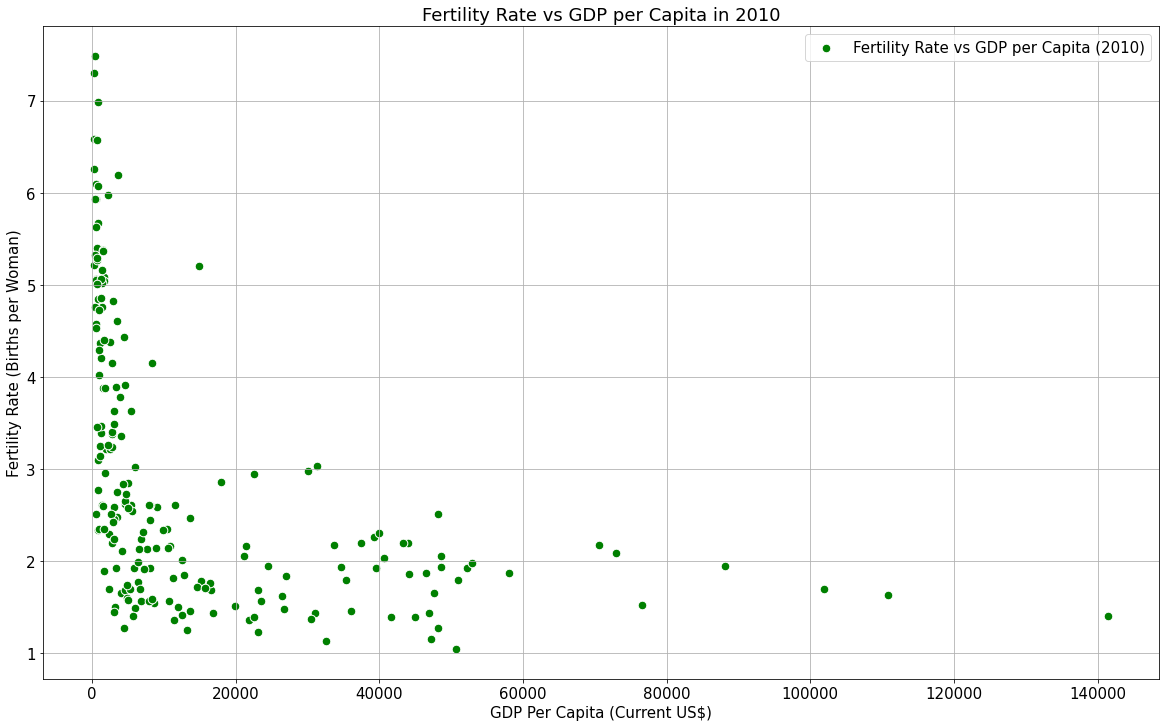

In [40]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize = (20, 12))

plt.scatter(gdp_fertility_filtered_1990_2010[gdp_fertility_filtered_1990_2010["Year"] == 2010]["GDP Per Capita"],
            gdp_fertility_filtered_1990_2010[gdp_fertility_filtered_1990_2010["Year"] == 2010]["Fertility Rate"],
            color = "green",
            edgecolors = "w",
            s = 75,
            label = "Fertility Rate vs GDP per Capita (2010)")

plt.title('Fertility Rate vs GDP per Capita in 2010')
plt.xlabel('GDP Per Capita (Current US$)')
plt.ylabel('Fertility Rate (Births per Woman)')

plt.legend()
plt.grid(True)
plt.show()

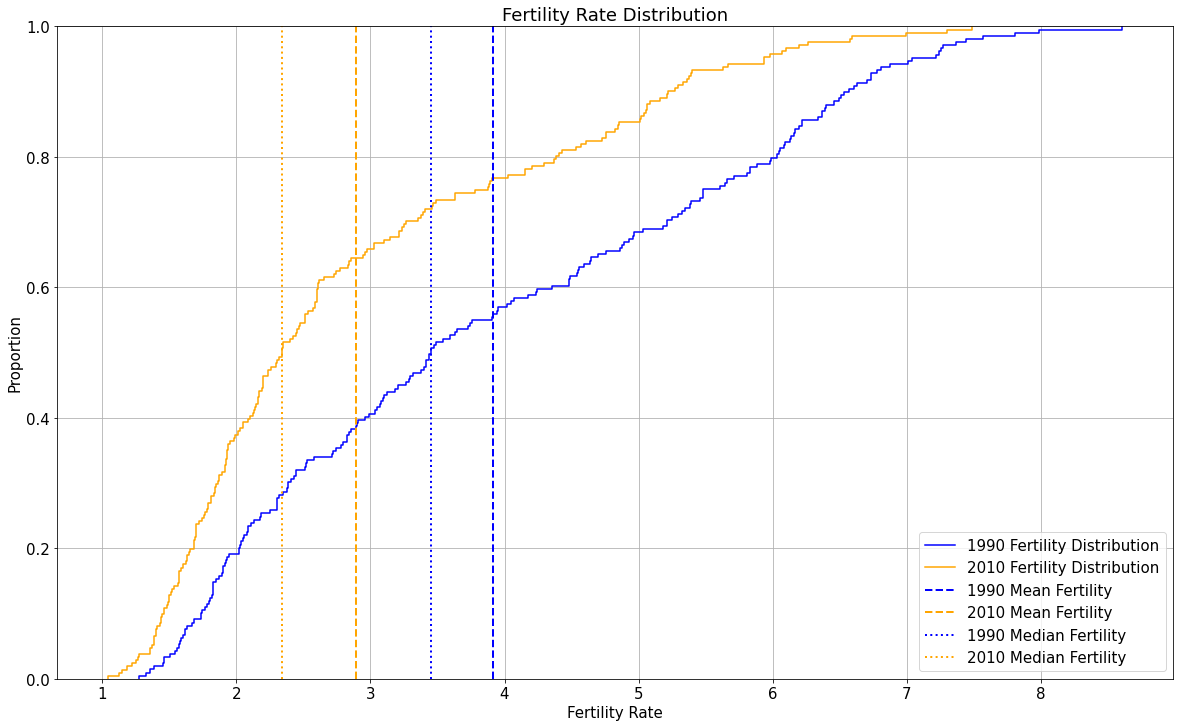

In [41]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize = (20, 12))

# distribution plots
# I wanted to do a distribution plot so I googled distribution plots python and I found that seaborn has it
# as a function, so I just used it. Did not know it existed
sns.ecdfplot(gdp_fertility_filtered_1990_2010[gdp_fertility_filtered_1990_2010["Year"] == 1990]["Fertility Rate"],
             label = "1990 Fertility Distribution",
             color = "blue")

sns.ecdfplot(gdp_fertility_filtered_1990_2010[gdp_fertility_filtered_1990_2010["Year"] == 2010]["Fertility Rate"],
             label = "2010 Fertility Distribution",
             color = "orange")

# mean lines (no pun intended)

plt.axvline(gdp_fertility_filtered_1990_2010[gdp_fertility_filtered_1990_2010["Year"] == 1990]["Fertility Rate"].mean(),
            linestyle = "--",
            color = "blue",
            linewidth = 2,
            label = "1990 Mean Fertility")

plt.axvline(gdp_fertility_filtered_1990_2010[gdp_fertility_filtered_1990_2010["Year"] == 2010]["Fertility Rate"].mean(),
            linestyle = "--",
            color = "orange",
            linewidth = 2,
            label = "2010 Mean Fertility")

# median lines
 
plt.axvline(gdp_fertility_filtered_1990_2010[gdp_fertility_filtered_1990_2010["Year"] == 1990]["Fertility Rate"].median(),
            linestyle = ":",
            color = "blue",
            linewidth = 2,
            label = "1990 Median Fertility")

plt.axvline(gdp_fertility_filtered_1990_2010[gdp_fertility_filtered_1990_2010["Year"] == 2010]["Fertility Rate"].median(),
            linestyle = ":",
            color = "orange",
            linewidth = 2,
            label = "2010 Median Fertility")
plt.title("Fertility Rate Distribution")
plt.legend()
plt.grid(True)

plt.show()

<h3>Question 5</h3>

In [42]:
hpi = pd.read_excel("hpi-data-2016.xlsx",
                    sheet_name = "Complete HPI data",
                    skiprows = 5)

cpi = pd.read_excel("CPI2016_Results.xlsx",
                    sheet_name = "CPI2016_FINAL_16Jan")

/opt/anaconda3/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


In [43]:
hpi = hpi[["Country", "HPI Rank"]]
hpi = hpi.dropna(subset = "HPI Rank")

In [44]:
# trimming the datasets from excel to only include the columns I'm interested in
cpi = cpi[["Country", "WB Code", "Region", "Rank"]]

In [45]:
# finding the unique countries in hpi and then making sure that they match with cpi
longer_list_of_countries = hpi["Country"].unique()
cpi_subset_of_hpi = cpi[cpi["Country"].isin(longer_list_of_countries)]

In [46]:
cpi_subset_of_hpi.columns = ["Country", "Country Code", "Region", "CPI Rank"]

In [47]:
# did the same thing with hpi to make sure they are included. I'm pretty sure I did something very innefficiently
# but that's fine for now. They should already be equivalent to each after doing it once, but that's fine
hpi_subset_of_cpi = hpi[hpi["Country"].isin(cpi_subset_of_hpi["Country"])]

In [48]:
# combing hpi and cpi together
hpi_and_cpi = combine_columns_from_another_dataframe(hpi_subset_of_cpi, cpi_subset_of_hpi)

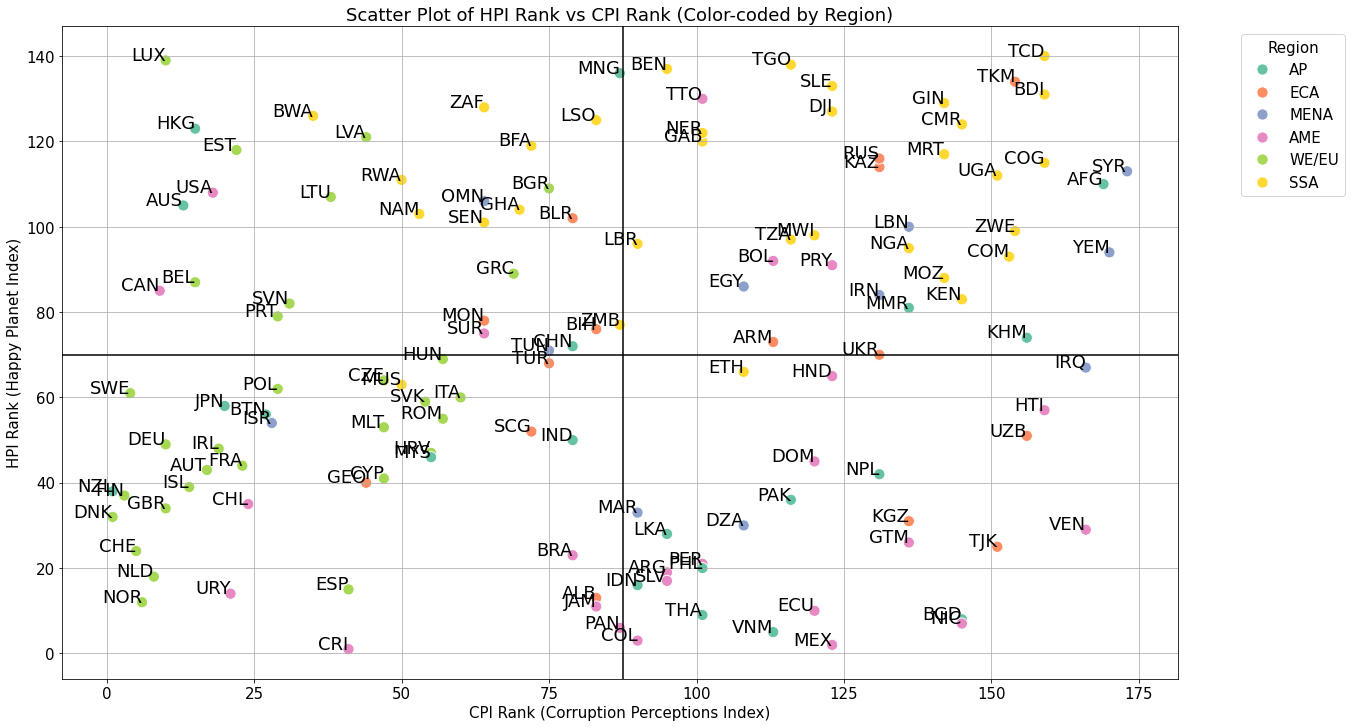

In [49]:
plt.figure(figsize = (20, 12))
plt.rcParams.update({'font.size': 15})

# I wanted to plot by region and country, so I googled the functionalities of seaborn. https://seaborn.pydata.org/
# looked up how to change colors and set legend

sns.scatterplot(data = hpi_and_cpi,
                x = 'CPI Rank',
                y = 'HPI Rank',
                hue = 'Region',
                palette = 'Set2',
                s = 125)

# this one adds text next to the countries and uses their x and y values to locate where they are on the graph

for i, row in hpi_and_cpi.iterrows():
    
    plt.text(row['CPI Rank'],
             row['HPI Rank'],
             row['Country Code'],
             fontsize = 18,
             ha = 'right')

plt.axvline(175/2, color = "black")
plt.axhline(140/2, color = "black")

plt.xlabel('CPI Rank (Corruption Perceptions Index)')
plt.ylabel('HPI Rank (Happy Planet Index)')
plt.title('Scatter Plot of HPI Rank vs CPI Rank (Color-coded by Region)')

plt.grid(True)
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()